In [1]:
from sys import version
import tensorflow
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.callbacks import EarlyStopping
from os import makedirs
makedirs("final_nn", exist_ok=True)

print(version)

Using TensorFlow backend.
3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
# Load and prepare training and xval data
TRAINING_FILE, XVAL_FILE, TEST_FILE = "../combined_data/15min/train.tsv.gz", "../combined_data/15min/xval.tsv.gz", "../combined_data/15min/test.tsv.gz"
train, xval, test = pd.read_csv(TRAINING_FILE, sep='\t'), pd.read_csv(XVAL_FILE, sep='\t'), pd.read_csv(TEST_FILE, sep='\t')
# Remove RapidRide routes.
train = train.loc[train['is_rapid'] == 0.,]
train.to_csv('../combined_data/15min/train_no_rr.tsv.gz', sep='\t', index=False)
xval = xval.loc[xval['is_rapid'] == 0.,]
xval.to_csv('../combined_data/15min/xval_no_rr.tsv.gz', sep='\t', index=False)
test = test.loc[test['is_rapid'] == 0.,]
test.to_csv('../combined_data/15min/test_no_rr.tsv.gz', sep='\t', index=False)

train['hour'] = train['trip_start_hr_15'].apply(lambda x: int(x.split("_")[0]))
xval['hour'] = xval['trip_start_hr_15'].apply(lambda x: int(x.split("_")[0]))
test['hour'] = test['trip_start_hr_15'].apply(lambda x: int(x.split("_")[0]))
print(f'Training dimension: {train.shape}')
print(f'Xval dimension: {xval.shape}')
print(f'Test dimension: {test.shape}')
print('\n'.join(train.columns))
#train.head(n=2).T

Training dimension: (482048, 21)
Xval dimension: (60253, 21)
Test dimension: (59999, 21)
opd_date
trip_start_hr_15
rte
dir
day_of_week
is_ns
is_rapid
is_weekend
orca_total
frac_disabled
frac_youth
frac_senior
frac_li
frac_uw
ons
region
start
end
type
summer
hour


In [3]:
NUM_COLS_TO_SCALE = [
    'orca_total', 
    'frac_disabled', 
    'frac_youth', 
    'frac_senior', 
    'frac_li', 
    'frac_uw',
    'hour'
]
NUM_COLS_OTHER = [
    #'hour'
]
X_CAT_COLS = [
    'is_ns', 
    #'is_rapid', 
    'is_weekend', 
    'trip_start_hr_15',
    'rte', 
    'dir', 
    'day_of_week', 
    'region', 
    'start', 
    'end', 
    'summer'
]

one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()

print("Creating X_train")
X_train = np.concatenate((
    scaler.fit_transform(train[NUM_COLS_TO_SCALE]),
    train[NUM_COLS_OTHER],
    one_hot_encoder.fit_transform(train[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_xval")
X_xval = np.concatenate((
    scaler.transform(xval[NUM_COLS_TO_SCALE]),
    xval[NUM_COLS_OTHER],
    one_hot_encoder.transform(xval[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_test")
X_test = np.concatenate((
    scaler.transform(test[NUM_COLS_TO_SCALE]),
    test[NUM_COLS_OTHER],
    one_hot_encoder.transform(test[X_CAT_COLS]).todense()
), axis=1)

y_train = train['ons']
y_xval = xval['ons']
y_test = test['ons']

np.save("final_nn/preprocessed_15m_X_train.npy", X_train)
np.save("final_nn/preprocessed_15m_X_xval.npy", X_xval)
np.save("final_nn/preprocessed_15m_X_test.npy", X_test)
np.save("final_nn/y_15m_train.npy", y_train)
np.save("final_nn/y_15m_xval.npy", y_xval)
np.save("final_nn/y_15m_test.npy", y_test)

Creating X_train
Creating X_xval
Creating X_test


In [30]:
X_train.shape

(482048, 414)

In [6]:
one_hot_encoder.categories_

column_labels = list()
for lab in NUM_COLS_TO_SCALE:
    column_labels.append(f'Scaled: {lab}')

for lab in NUM_COLS_OTHER:
    column_labels.append(f'Numeric: {lab}')

for i, cat in enumerate(X_CAT_COLS):
    for cat_val in one_hot_encoder.categories_[i]:
        column_labels.append(f'{cat}: {cat_val}')

assert len(column_labels) == X_train.shape[1], f"Len of column labels {len(column_labels)} matches dimension of training set {X_train.shape}"

import pickle
with open('final_nn/15m_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder, f)

with open('final_nn/15m_standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('final_nn/15m_column_labels.pkl', 'wb') as f:
    pickle.dump(column_labels, f)

print(column_labels)

['Scaled: orca_total', 'Scaled: frac_disabled', 'Scaled: frac_youth', 'Scaled: frac_senior', 'Scaled: frac_li', 'Scaled: frac_uw', 'Scaled: hour', 'is_ns: 0.0', 'is_ns: 1.0', 'is_weekend: 0.0', 'is_weekend: 1.0', 'trip_start_hr_15: 00_0', 'trip_start_hr_15: 00_15', 'trip_start_hr_15: 00_30', 'trip_start_hr_15: 00_45', 'trip_start_hr_15: 01_0', 'trip_start_hr_15: 01_15', 'trip_start_hr_15: 01_30', 'trip_start_hr_15: 01_45', 'trip_start_hr_15: 02_0', 'trip_start_hr_15: 02_15', 'trip_start_hr_15: 02_30', 'trip_start_hr_15: 02_45', 'trip_start_hr_15: 03_0', 'trip_start_hr_15: 03_15', 'trip_start_hr_15: 03_30', 'trip_start_hr_15: 03_45', 'trip_start_hr_15: 04_0', 'trip_start_hr_15: 04_15', 'trip_start_hr_15: 04_30', 'trip_start_hr_15: 04_45', 'trip_start_hr_15: 05_0', 'trip_start_hr_15: 05_15', 'trip_start_hr_15: 05_30', 'trip_start_hr_15: 05_45', 'trip_start_hr_15: 06_0', 'trip_start_hr_15: 06_15', 'trip_start_hr_15: 06_30', 'trip_start_hr_15: 06_45', 'trip_start_hr_15: 07_0', 'trip_start_

In [32]:
# Find the best possible model using the xval data
from skopt import gp_minimize

def model_fit(params):   # size=600, dropout=0.1, lr=0.2, max_iter=25
    size, dropout, lr = params
    max_iter = 25
    print(f"Fitting model with an initial layer of width {size}, dropout={dropout} and lr={lr}")
    model = Sequential()
    model.add(Dense(size, activation="sigmoid", input_dim=X_train.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=max_iter, batch_size=256, callbacks=[es])
    return model.evaluate(X_xval, y_xval)

best = gp_minimize(model_fit, [
        (200, 1200),  # size
        (0.1, 0.5),   # dropout
        (0.1, 1)      # lr
    ],
    n_calls=25,
    n_random_starts=3
)

Fitting model with an initial layer of width 820, dropout=0.2253151264543593 and lr=0.9329157092815854
Train on 482048 samples, validate on 60253 samples
Epoch 1/25
482048/482048 [==============================] - 49s 101us/step - loss: 8.2167 - val_loss: 6.6112
Epoch 2/25
482048/482048 [==============================] - 49s 101us/step - loss: 7.0947 - val_loss: 6.1950
Epoch 3/25
482048/482048 [==============================] - 49s 102us/step - loss: 6.8251 - val_loss: 6.2546
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping
60253/60253 [==============================] - 4s 65us/step
Fitting model with an initial layer of width 1053, dropout=0.2476364041855147 and lr=0.654224356418054
Train on 482048 samples, validate on 60253 samples
Epoch 1/25
482048/482048 [==============================] - 57s 118us/step - loss: 7.6382 - val_loss: 6.1986
Epoch 2/25
482048/482048 [==============================] - 58s 119us/step - loss: 6.5592 - val_loss: 6.1296
Epoc

KeyboardInterrupt: 

In [10]:
model = Sequential()
model.add(Dense(1020, activation="sigmoid", input_dim=X_train.shape[1]))
model.add(Dropout(0.23544620354920223))
model.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.16287174712352556, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer=sgd)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=25, batch_size=256, callbacks=[es])

Train on 482048 samples, validate on 60253 samples
Epoch 1/25
482048/482048 [==============================] - 58s 119us/step - loss: 7.6116 - val_loss: 6.4744
Epoch 2/25
482048/482048 [==============================] - 56s 115us/step - loss: 6.4908 - val_loss: 6.2425
Epoch 3/25
482048/482048 [==============================] - 52s 108us/step - loss: 6.2136 - val_loss: 5.9749
Epoch 4/25
482048/482048 [==============================] - 52s 109us/step - loss: 6.0621 - val_loss: 5.8031
Epoch 5/25
482048/482048 [==============================] - 55s 113us/step - loss: 5.9765 - val_loss: 5.6810
Epoch 6/25
482048/482048 [==============================] - 56s 116us/step - loss: 5.9208 - val_loss: 5.6519
Epoch 7/25
482048/482048 [==============================] - 56s 116us/step - loss: 5.8820 - val_loss: 5.6024
Epoch 8/25
482048/482048 [==============================] - 53s 110us/step - loss: 5.8401 - val_loss: 5.5940
Epoch 9/25
482048/482048 [==============================] - 53s 109us/step - 

In [7]:
from keras.models import model_from_json

with open("final_nn/model_15min.json", "r") as json_file:
    model = model_from_json(json_file.read())
sgd = SGD(lr=0.16287174712352556, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer=sgd)
model.load_weights("final_nn/model_15min_weights_train.h5")
print(f'Test perf: {model.evaluate(X_test, y_test, batch_size=128)}')


59999/59999 [==============================] - 2s 36us/step
Test perf: 5.507735068365845


In [12]:
model_json = model.to_json()
with open("final_nn/model_15min.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("final_nn/model_15min_weights_train.h5")

In [13]:
# # Create test set predictions
# from keras.models import model_from_json

# with open("final_nn/model_15min.json", "r") as json_file:
#     model = model_from_json(json_file.read())

# model.load_weights("final_nn/model_15min_weights_train.h5")

with open("../predictions/final_nn_15min_test.txt", 'wt') as f:
    for val in model.predict(X_test).squeeze():
        f.write(f'{val:.15f}\n')

with open("../predictions/final_nn_15min_xval.txt", 'wt') as f:
    for val in model.predict(X_xval).squeeze():
        f.write(f'{val:.15f}\n')

In [2]:
# Fit another model on 30m data.
# Load and prepare training and xval data
TRAINING_FILE, XVAL_FILE, TEST_FILE = "../combined_data/30min/train.tsv.gz", "../combined_data/30min/xval.tsv.gz", "../combined_data/30min/test.tsv.gz"
train, xval, test = pd.read_csv(TRAINING_FILE, sep='\t'), pd.read_csv(XVAL_FILE, sep='\t'), pd.read_csv(TEST_FILE, sep='\t')
# Remove RapidRide routes.
train = train.loc[train['is_rapid'] == 0.,]
train.to_csv('../combined_data/30min/train_no_rr.tsv.gz', sep='\t', index=False)
xval = xval.loc[xval['is_rapid'] == 0.,]
xval.to_csv('../combined_data/30min/xval_no_rr.tsv.gz', sep='\t', index=False)
test = test.loc[test['is_rapid'] == 0.,]
test.to_csv('../combined_data/30min/test_no_rr.tsv.gz', sep='\t', index=False)

train['hour'] = train['trip_start_hr_30'].apply(lambda x: int(x.split("_")[0]))
xval['hour'] = xval['trip_start_hr_30'].apply(lambda x: int(x.split("_")[0]))
test['hour'] = test['trip_start_hr_30'].apply(lambda x: int(x.split("_")[0]))

X_NUM_COLS = [
    'orca_total', 
    'frac_disabled', 
    'frac_youth', 
    'frac_senior', 
    'frac_li', 
    'frac_uw',
    'hour'
]
X_CAT_COLS = [
    'is_ns', 
    'is_rapid', 
    'is_weekend', 
    'trip_start_hr_30',
    'rte', 
    'dir', 
    'day_of_week', 
    'region', 
    'start', 
    'end', 
    'summer'
]

one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()

print("Creating X_train")
X_train = np.concatenate((
    scaler.fit_transform(train[X_NUM_COLS]),
    one_hot_encoder.fit_transform(train[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_xval")
X_xval = np.concatenate((
    scaler.transform(xval[X_NUM_COLS]),
    one_hot_encoder.transform(xval[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_test")
X_test = np.concatenate((
    scaler.transform(test[X_NUM_COLS]),
    one_hot_encoder.transform(test[X_CAT_COLS]).todense()
), axis=1)

y_train = train['ons']
y_xval = xval['ons']
y_test = test['ons']

np.save("final_nn/preprocessed_30m_X_train.npy", X_train)
np.save("final_nn/preprocessed_30m_X_xval.npy", X_xval)
np.save("final_nn/preprocessed_30m_X_test.npy", X_test)
np.save("final_nn/y_30m_train.npy", y_train)
np.save("final_nn/y_30m_xval.npy", y_xval)
np.save("final_nn/y_30m_test.npy", y_test)

Creating X_train
Creating X_xval
Creating X_test


In [3]:
column_labels = list()
for lab in X_NUM_COLS:
    column_labels.append(f'num: {lab}')

for i, cat in enumerate(X_CAT_COLS):
    for cat_val in one_hot_encoder.categories_[i]:
        column_labels.append(f'{cat}: {cat_val}')

assert len(column_labels) == X_train.shape[1], f"Len of column labels {len(column_labels)} matches dimension of training set {X_train.shape}"

import pickle
with open('final_nn/30m_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder, f)

with open('final_nn/30m_standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('final_nn/30m_column_labels.pkl', 'wb') as f:
    pickle.dump(column_labels, f)


In [18]:
# Find the best possible model using the xval data
from skopt import gp_minimize

def model_fit(params):
    size, dropout, lr = params
    max_iter = 25
    print(f"Fitting model with an initial layer of width {size}, dropout={dropout} and lr={lr}")
    model = Sequential()
    model.add(Dense(size, activation="sigmoid", input_dim=X_train.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=max_iter, batch_size=256, callbacks=[es])
    return model.evaluate(X_xval, y_xval)

best = gp_minimize(model_fit, [
        (800, 2000),  # size
        (0.1, 0.5),   # dropout
        (0.1, 1)      # lr
    ],
    n_calls=25,
    n_random_starts=5
)

Fitting model with an initial layer of width 914, dropout=0.45775133977570537 and lr=0.37312365193316577
Train on 385130 samples, validate on 48131 samples
Epoch 1/25
385130/385130 [==============================] - 43s 113us/step - loss: 9.6141 - val_loss: 7.9202
Epoch 2/25
385130/385130 [==============================] - 41s 106us/step - loss: 8.3410 - val_loss: 7.8579
Epoch 3/25
385130/385130 [==============================] - 38s 99us/step - loss: 8.0297 - val_loss: 7.5099
Epoch 4/25
385130/385130 [==============================] - 36s 94us/step - loss: 7.8929 - val_loss: 7.1742
Epoch 5/25
385130/385130 [==============================] - 37s 97us/step - loss: 7.7723 - val_loss: 7.4899
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping
48131/48131 [==============================] - 3s 63us/step
Fitting model with an initial layer of width 937, dropout=0.2086839863750497 and lr=0.7672984471122088
Train on 385130 samples, validate on 48131 samples
Epoch

KeyboardInterrupt: 

In [7]:
# After running the above step on cloud compute, the best model I found was this:
# 2000, dropout=0.1 and lr=0.1
model = Sequential()
model.add(Dense(2000, activation="sigmoid", input_dim=X_train.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer=sgd)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=25, batch_size=256, callbacks=[es])
model.evaluate(X_test, y_test)




Train on 385130 samples, validate on 48131 samples
Epoch 1/25





385130/385130 [==============================] - 85s 220us/step - loss: 10.4403 - val_loss: 9.2446
Epoch 2/25
385130/385130 [==============================] - 77s 200us/step - loss: 8.5830 - val_loss: 8.2695
Epoch 3/25
385130/385130 [==============================] - 72s 187us/step - loss: 8.0249 - val_loss: 7.6752
Epoch 4/25
385130/385130 [==============================] - 71s 183us/step - loss: 7.6877 - val_loss: 7.4072
Epoch 5/25
385130/385130 [==============================] - 83s 216us/step - loss: 7.4562 - val_loss: 7.1782
Epoch 6/25
385130/385130 [==============================] - 77s 201us/step - loss: 7.2813 - val_loss: 7.0189
Epoch 7/25
385130/385130 [==============================] - 76s 198us/step - loss: 7.1571 - val_loss: 7.0781
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
48169/48169 [==============================] - 6s 120us/step


6.991281128495925

In [8]:
model_json = model.to_json()
with open("final_nn/model_30min.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("final_nn/model_30min_weights_train.h5")

In [9]:
# Create test set predictions out of the better performing model
from keras.models import model_from_json

#with open("final_nn/model_30min.json", "r") as json_file:
#    model = model_from_json(json_file.read())

#model.load_weights("final_nn/model_30min_weights_train.h5")

with open("../predictions/final_nn_30min_test.txt", 'wt') as f:
    for val in model.predict(X_test).squeeze():
        f.write(f'{val:.15f}\n')

with open("../predictions/final_nn_30min_xval.txt", 'wt') as f:
    for val in model.predict(X_xval).squeeze():
        f.write(f'{val:.15f}\n')

In [12]:
# And for 1hr

TRAINING_FILE, XVAL_FILE, TEST_FILE = "../combined_data/hr/train.tsv.gz", "../combined_data/hr/xval.tsv.gz", "../combined_data/hr/test.tsv.gz"
train, xval, test = pd.read_csv(TRAINING_FILE, sep='\t'), pd.read_csv(XVAL_FILE, sep='\t'), pd.read_csv(TEST_FILE, sep='\t')
# Remove RapidRide routes.
train = train.loc[train['is_rapid'] == 0.,]
train.to_csv('../combined_data/hr/train_no_rr.tsv.gz', sep='\t', index=False)
xval = xval.loc[xval['is_rapid'] == 0.,]
xval.to_csv('../combined_data/hr/xval_no_rr.tsv.gz', sep='\t', index=False)
test = test.loc[test['is_rapid'] == 0.,]
test.to_csv('../combined_data/hr/test_no_rr.tsv.gz', sep='\t', index=False)

train['hour'] = train['trip_start_hr'].apply(int)
xval['hour'] = xval['trip_start_hr'].apply(int)
test['hour'] = test['trip_start_hr'].apply(int)
print(f'Training dimension: {train.shape}')
print(f'Xval dimension: {xval.shape}')
print(f'Test dimension: {test.shape}')

X_NUM_COLS = [
    'orca_total', 
    'frac_disabled', 
    'frac_youth', 
    'frac_senior', 
    'frac_li', 
    'frac_uw',
    'hour'
]
X_CAT_COLS = [
    'is_ns', 
    'is_rapid', 
    'is_weekend', 
    'trip_start_hr',
    'rte', 
    'dir', 
    'day_of_week', 
    'region', 
    'start', 
    'end', 
    'summer'
]

one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()

print("Creating X_train")
X_train = np.concatenate((
    scaler.fit_transform(train[X_NUM_COLS]),
    one_hot_encoder.fit_transform(train[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_xval")
X_xval = np.concatenate((
    scaler.transform(xval[X_NUM_COLS]),
    one_hot_encoder.transform(xval[X_CAT_COLS]).todense()
), axis=1)

print("Creating X_test")
X_test = np.concatenate((
    scaler.transform(test[X_NUM_COLS]),
    one_hot_encoder.transform(test[X_CAT_COLS]).todense()
), axis=1)

y_train = train['ons']
y_xval = xval['ons']
y_test = test['ons']

np.save("final_nn/preprocessed_hr_X_train.npy", X_train)
np.save("final_nn/preprocessed_hr_X_xval.npy", X_xval)
np.save("final_nn/preprocessed_hr_X_test.npy", X_test)
np.save("final_nn/y_hr_train.npy", y_train)
np.save("final_nn/y_hr_xval.npy", y_xval)
np.save("final_nn/y_hr_test.npy", y_test)

Training dimension: (250334, 21)
Xval dimension: (31572, 21)
Test dimension: (31534, 21)
Creating X_train
Creating X_xval
Creating X_test


In [13]:
column_labels = list()
for lab in X_NUM_COLS:
    column_labels.append(f'num: {lab}')

for i, cat in enumerate(X_CAT_COLS):
    for cat_val in one_hot_encoder.categories_[i]:
        column_labels.append(f'{cat}: {cat_val}')

assert len(column_labels) == X_train.shape[1], f"Len of column labels {len(column_labels)} matches dimension of training set {X_train.shape}"

import pickle
with open('final_nn/hr_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder, f)

with open('final_nn/hr_standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('final_nn/hr_column_labels.pkl', 'wb') as f:
    pickle.dump(column_labels, f)


In [14]:
from skopt import gp_minimize

def model_fit(params):
    size, dropout, lr = params
    max_iter = 25
    print(f"Fitting model with an initial layer of width {size}, dropout={dropout} and lr={lr}")
    model = Sequential()
    model.add(Dense(size, activation="sigmoid", input_dim=X_train.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_absolute_error', optimizer=sgd)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=max_iter, batch_size=256, callbacks=[es])
    return model.evaluate(X_xval, y_xval)

best = gp_minimize(model_fit, [
        (800, 2000),  # size
        (0.1, 0.5),   # dropout
        (0.1, 1)      # lr
    ],
    n_calls=25,
    n_random_starts=5
)

Fitting model with an initial layer of width 955, dropout=0.26130464669525444 and lr=0.9597436993934857
Train on 250334 samples, validate on 31572 samples
Epoch 1/25
250334/250334 [==============================] - 26s 104us/step - loss: 16.4086 - val_loss: 12.1715
Epoch 2/25
250334/250334 [==============================] - 28s 111us/step - loss: 13.1495 - val_loss: 12.7758
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping
31572/31572 [==============================] - 2s 62us/step
Fitting model with an initial layer of width 876, dropout=0.11736573673602974 and lr=0.828347108581263
Train on 250334 samples, validate on 31572 samples
Epoch 1/25
250334/250334 [==============================] - 25s 100us/step - loss: 14.4533 - val_loss: 11.6517
Epoch 2/25
250334/250334 [==============================] - 24s 95us/step - loss: 11.7358 - val_loss: 11.0432
Epoch 3/25
250334/250334 [==============================] - 23s 94us/step - loss: 11.1577 - val_loss: 10.

KeyboardInterrupt: 

In [15]:
model = Sequential()
model.add(Dense(2000, activation="sigmoid", input_dim=X_train.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.22902961281, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer=sgd)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=25, batch_size=256, callbacks=[es])

Train on 250334 samples, validate on 31572 samples
Epoch 1/25
250334/250334 [==============================] - 53s 210us/step - loss: 14.8621 - val_loss: 12.2950
Epoch 2/25
250334/250334 [==============================] - 46s 184us/step - loss: 11.6099 - val_loss: 11.0648
Epoch 3/25
250334/250334 [==============================] - 50s 200us/step - loss: 10.7366 - val_loss: 10.4459
Epoch 4/25
250334/250334 [==============================] - 53s 211us/step - loss: 10.2068 - val_loss: 10.2447
Epoch 5/25
250334/250334 [==============================] - 46s 186us/step - loss: 9.8592 - val_loss: 9.7304
Epoch 6/25
250334/250334 [==============================] - 44s 174us/step - loss: 9.6412 - val_loss: 9.6784
Epoch 7/25
250334/250334 [==============================] - 42s 169us/step - loss: 9.4873 - val_loss: 9.6185
Epoch 8/25
250334/250334 [==============================] - 47s 187us/step - loss: 9.3841 - val_loss: 9.4021
Epoch 9/25
250334/250334 [==============================] - 47s 189us

In [16]:
model.evaluate(X_test, y_test)

31534/31534 [==============================] - 3s 101us/step


9.268288187515822

In [17]:
model_json = model.to_json()
with open("final_nn/model_hr.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("final_nn/model_hr_weights_train.h5")

In [18]:
# Create test set predictions out of the better performing model
from keras.models import model_from_json

# with open("final_nn/model_hr.json", "r") as json_file:
#     model = model_from_json(json_file.read())

# model.load_weights("final_nn/model_hr_weights_train.h5")

with open("../predictions/final_nn_hr_test.txt", 'wt') as f:
    for val in model.predict(X_test).squeeze():
        f.write(f'{val:.15f}\n')

with open("../predictions/final_nn_hr_xval.txt", 'wt') as f:
    for val in model.predict(X_xval).squeeze():
        f.write(f'{val:.15f}\n')

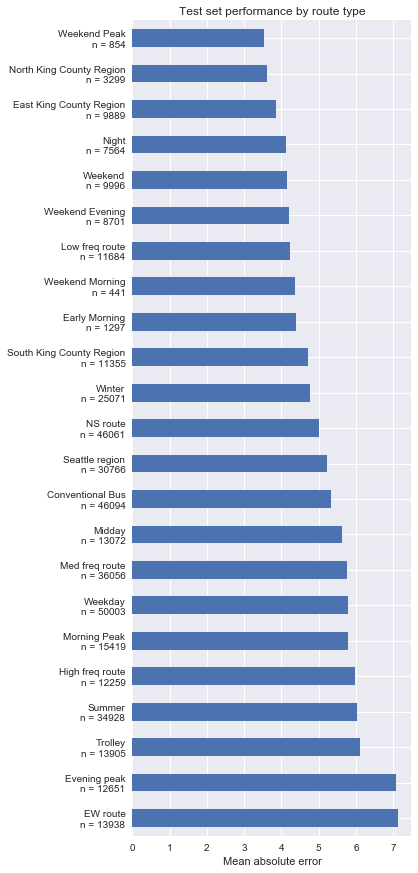

In [49]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')
d = pd.read_csv("../evaluation/15m_test_group_perf.csv")
d['lab'] = d['group'].apply(str) + '\nn = ' + d['n'].apply(str)
d = d.set_index(['lab'])
plt.figure(figsize=(5,15))
d['mae'].plot.barh()
plt.title("Test set performance by route type")
plt.xlabel("Mean absolute error")
plt.ylabel("")
plt.show()

In [23]:
d

,mae,n
group,,
EW route,7.133176,13938
Evening peak,7.068965,12651
Trolley,6.100806,13905
Summer,6.030428,34928
High freq route,5.984582,12259
Morning Peak,5.782668,15419
Weekday,5.779803,50003
Med freq route,5.763225,36056
Midday,5.629234,13072
